In [1]:
"""
Example Usage of ParticleFlowFilter Class

This script demonstrates how to use the ParticleFlowFilter class
to perform data assimilation on the Lorenz 96 model.
"""

import tensorflow as tf
import numpy as np
from pff import ParticleFlowFilter

from utils_pff_l96_rk4 import (
    L96_RK4, generate_L96_trajectory, generate_observations,
    generate_initial_ensemble, run_ensemble_no_DA,
    generate_Hx_si, H_linear_adjoint
)

# Set random seeds for reproducibility
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
tf.random.set_seed(RANDOM_SEED)

# 1. EXPERIMENT SETUP

In [2]:
# Data assimilation settings
nt = 200               # Number of integration timesteps
warm_nt = 1000         # Warm up time for Lorenz model
np_particles = 30      # Number of particles

# L96 model parameters
dim = 40               # Dimension of Lorenz 96 model
F = 8.0                # Forcing parameter
dt = 0.01              # Time resolution

# Background error covariance
Q = 2 * tf.eye(dim, dtype=tf.float32)


# Observation setup
dim_interval = 4            # Observation density
obs_input = np.arange(dim_interval-1, dim, dim_interval)  # Python uses 0-indexing
ny_obs = len(obs_input)

nx = 40                     # Full state dimension
obs_interval = 4            # Observation frequency
obs_err = 0.3               # Observation error standard deviation
R = obs_err**2 * tf.eye(ny_obs, dtype=tf.float32)

# 2. GENERATE TRUTH AND OBSERVATIONS

In [3]:
# Generate truth trajectory
Xt = generate_L96_trajectory(
        dim, warm_nt, nt, dt, F, L96_RK4
)

# Generate observations
y_obs, obs_indices, dim_indices = generate_observations(
    Xt, nt, warm_nt, obs_interval, dim_interval, R, nx
)

# Generate initial ensemble
X = generate_initial_ensemble(
    Xt, warm_nt, dim, np_particles, nt, Q
)

# Run free forecast (no DA) for comparison
XnoDA = run_ensemble_no_DA(X, nt, dt, F, L96_RK4)

Integrating L96 model...
  Step 200/1200
  Step 400/1200
  Step 600/1200
  Step 800/1200
  Step 1000/1200
Initial ensemble generated with 30 particles
Running ensemble without DA (free run)...
  Timestep 50/200
  Timestep 100/200
  Timestep 150/200
Free run complete!


# 3. INITIALIZE PARTICLE FLOW FILTER

In [4]:
alpha = 1.0 / np_particles

# PFF prior assumptions
inflation_fac = 1.25        # Inflation factor for prior covariance
r_influ = 4                 # Localization radius

# PFF iteration parameters
max_pseudo_step = 150       # Maximum number of iterations
eps_init = 5e-2             # Initial learning rate
stop_cri_percentage = 0.05  # Percentage-based stopping criterion
min_learning_rate = 1e-5    # Minimum learning rate
total_obs = nt // obs_interval  # Total number of observations

In [5]:
pff = ParticleFlowFilter(
    dim=dim,
    np_particles=np_particles,
    nt=nt,
    obs_interval=obs_interval,
    dim_interval=dim_interval,
    total_obs = total_obs,
    nx=nx,
    R=R,
    alpha=alpha,
    max_pseudo_step=max_pseudo_step,
    eps_init=eps_init,
    stop_cri_percentage=stop_cri_percentage,
    min_learning_rate=min_learning_rate,
    inflation_fac=inflation_fac,
    r_influ=r_influ,
    generate_Hx_si=generate_Hx_si,
    H_linear_adjoint=H_linear_adjoint
)

# 4.RUN DATA ASSIMILATION


In [6]:
DA_run = True

In [7]:
if DA_run:
    # Convert X to list format
    X_list = [X[:, :, i] for i in range(nt)]
    
    # Define model step function
    def model_step(X_current):
        """Wrapper for L96_RK4 model step."""
        return L96_RK4(X_current, dt, F=8)
    
    # Run PFF assimilation
    X_list_updated = pff.run(
        X_list=X_list,
        y_obs=y_obs,
        model_step=model_step,
        t_start=0,
        verbose=False
    )
    
    # Convert back to array format
    X_DA = tf.stack(X_list_updated, axis=2)
    
    print("\nData assimilation complete!")
    print(f"Output shape: {X_DA.shape}")
    
    # Save results
    # np.save('X_DA.npy', X_DA.numpy())
    
    # Get gradient history for diagnostics
    # grad_history = pff.get_gradient_history()
    # np.save('gradient_history.npy', grad_history)


    [Note] eps changed to 5.00e-02, redo iteration
    [Note] eps changed to 3.33e-02, redo iteration
    [Note] eps changed to 2.22e-02, redo iteration
    [Note] eps changed to 2.22e-02, redo iteration
    [Note] eps changed to 1.48e-02, redo iteration
    [Note] eps changed to 9.88e-03, redo iteration
    [Note] eps changed to 1.48e-02, redo iteration
    [Note] eps changed to 9.88e-03, redo iteration
    [Note] eps changed to 6.58e-03, redo iteration
    [Note] eps changed to 9.88e-03, redo iteration
    [Note] eps changed to 6.58e-03, redo iteration
    [Note] eps changed to 4.39e-03, redo iteration
    [Note] eps changed to 2.93e-03, redo iteration
    [Note] eps changed to 1.95e-03, redo iteration
    [Note] eps changed to 1.30e-03, redo iteration
    [Note] eps changed to 8.67e-04, redo iteration
    [Note] eps changed to 5.78e-04, redo iteration
    [Note] eps changed to 1.48e-02, redo iteration
    [Note] eps changed to 9.88e-03, redo iteration
    [Note] eps changed to 6.58e


RMSE Statistics:
  DA run - Mean RMSE: 1.7062
  No-DA run - Mean RMSE: 3.1678
  Improvement: 46.14%


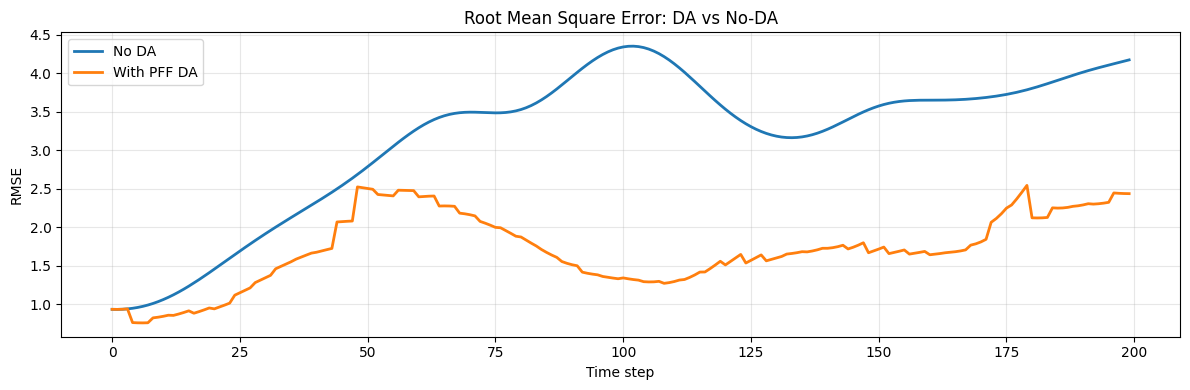

/var/folders/fr/7vt2v5bs1f37tzqpnrrq0l880000gn/T/ipykernel_3184/2799045909.py:46: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


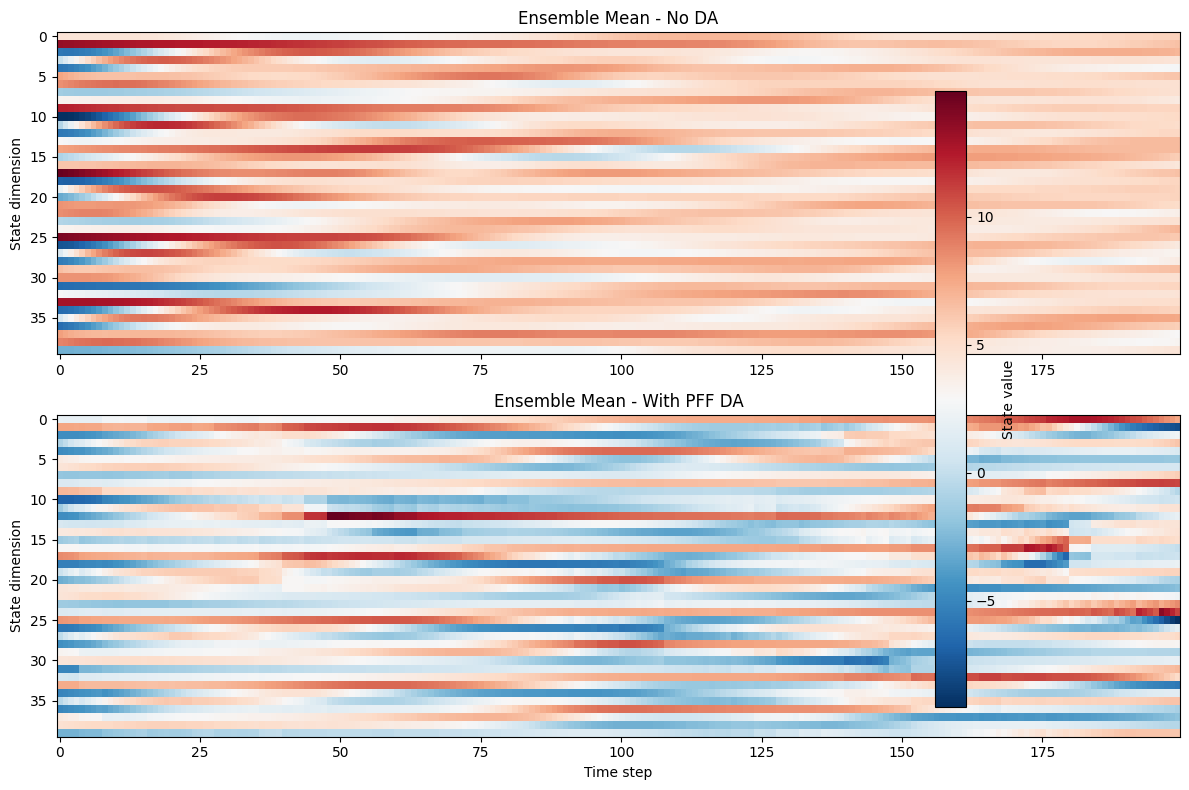

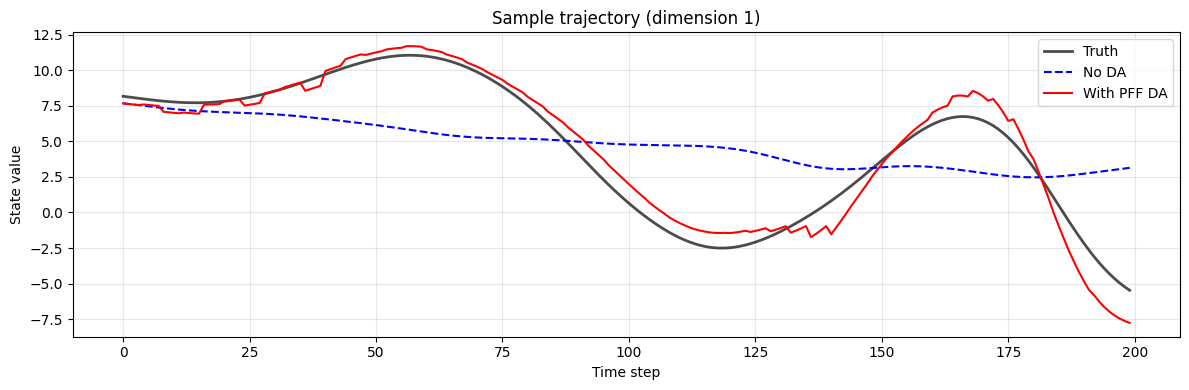

In [8]:
import matplotlib.pyplot as plt

# Calculate RMSE for both DA and no-DA runs
truth = Xt[:, warm_nt:warm_nt+nt]

# Ensemble mean
X_mean_DA = np.mean(X_DA, axis=1)
X_mean_noDA = np.mean(XnoDA, axis=1)

# RMSE over time
rmse_DA = np.sqrt(np.mean((X_mean_DA - truth)**2, axis=0))
rmse_noDA = np.sqrt(np.mean((X_mean_noDA - truth)**2, axis=0))

print(f"\nRMSE Statistics:")
print(f"  DA run - Mean RMSE: {np.mean(rmse_DA):.4f}")
print(f"  No-DA run - Mean RMSE: {np.mean(rmse_noDA):.4f}")
print(f"  Improvement: {(1 - np.mean(rmse_DA)/np.mean(rmse_noDA))*100:.2f}%")

# Plot RMSE comparison
plt.figure(figsize=(12, 4))
plt.plot(rmse_noDA, label='No DA', linewidth=2)
plt.plot(rmse_DA, label='With PFF DA', linewidth=2)
plt.xlabel('Time step')
plt.ylabel('RMSE')
plt.title('Root Mean Square Error: DA vs No-DA')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Plot ensemble spread
fig, axes = plt.subplots(2, 1, figsize=(12, 8))

# No-DA run
axes[0].imshow(X_mean_noDA, aspect='auto', cmap='RdBu_r', interpolation='nearest')
axes[0].set_title('Ensemble Mean - No DA')
axes[0].set_ylabel('State dimension')

# DA run
im = axes[1].imshow(X_mean_DA, aspect='auto', cmap='RdBu_r', interpolation='nearest')
axes[1].set_title('Ensemble Mean - With PFF DA')
axes[1].set_xlabel('Time step')
axes[1].set_ylabel('State dimension')

plt.colorbar(im, ax=axes, label='State value')
plt.tight_layout()
plt.show()

# Plot sample trajectory
sample_dim = 1
plt.figure(figsize=(12, 4))
plt.plot(truth[sample_dim, :], 'k-', linewidth=2, label='Truth', alpha=0.7)
plt.plot(X_mean_noDA[sample_dim, :], 'b--', linewidth=1.5, label='No DA')
plt.plot(X_mean_DA[sample_dim, :], 'r-', linewidth=1.5, label='With PFF DA')
plt.xlabel('Time step')
plt.ylabel('State value')
plt.title(f'Sample trajectory (dimension {sample_dim})')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# 5.ALTERNATIVE: MANUAL ASSIMILATION AT EACH TIME

In [9]:
# If you want more control, you can manually call assimilate() at each time:
if True:  # Set to True to run this example
    X_list_manual = [X[:, :, i] for i in range(nt)]
    t = 0
    
    while t < nt - 1:
        # Forecast
        X_next = L96_RK4(X_list_manual[t], dt, F)
        X_list_manual[t+1] = X_next
        
        # Check for observation
        if (t + 1) % obs_interval == 0:
            obs_time = (t + 1) // obs_interval -1
            
            # Perform assimilation
            X_list_manual[t+1], iterations = pff.assimilate(
                X_list=X_list_manual,
                y_obs=y_obs,
                t=t,
                obs_time=obs_time,
                verbose=True
            )
            
            print(f"Assimilation at t={t+1} completed in {iterations} iterations")
        
        t += 1


  Time t=4, Observation 1/50
    Iteration s=0, norm=100.00%, eps=5.00e-02
    Iteration s=10, norm=23.15%, eps=7.50e-02
    [Note] eps changed to 5.00e-02, redo iteration
    [Note] eps changed to 3.33e-02, redo iteration
    [Note] eps changed to 2.22e-02, redo iteration
    Iteration s=20, norm=13.26%, eps=3.33e-02
    [Note] eps changed to 2.22e-02, redo iteration
    [Note] eps changed to 1.48e-02, redo iteration
    [Note] eps changed to 9.88e-03, redo iteration
    Iteration s=30, norm=13.60%, eps=1.48e-02
    Iteration s=40, norm=11.26%, eps=2.22e-02
    [Note] eps changed to 1.48e-02, redo iteration
    [Note] eps changed to 9.88e-03, redo iteration
    Iteration s=40, norm=11.85%, eps=9.88e-03
    [Note] eps changed to 6.58e-03, redo iteration
    Iteration s=40, norm=11.94%, eps=6.58e-03
    Iteration s=50, norm=11.48%, eps=9.88e-03
    [Note] eps changed to 9.88e-03, redo iteration
    [Note] eps changed to 6.58e-03, redo iteration
    [Note] eps changed to 4.39e-03, redo 